# Importation des librairies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Importation des données

In [2]:
df = pd.read_csv('./cardio_train.csv', sep=';')
df.drop('id', axis=1, inplace=True)
print(df.shape)
df.head()

(70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Aperçu rapide & types

In [3]:
print("Nombre de lignes, colonnes:", df.shape)
display(df.info())
display(df.describe(include='all').T)

Nombre de lignes, colonnes: (70000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


None

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0


# 2. Prétraitement des données

## a-Handling des missing values (détection)

In [4]:
missing = df.isnull().sum().sort_values(ascending=False)
print(missing)

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


## b-Stratégies d'imputation

<span style="color: red;" >Démonstration pratique (avec simulation)</span>

#### Étape 1 : Simuler 10% de valeurs manquantes dans weight

In [5]:
df_missing = df.copy()

# Simulation : retirer 10% des valeurs de weight
df_missing.loc[df_missing.sample(frac=0.1, random_state=42).index, 'weight'] = None

df_missing['weight'].isnull().sum()

print("Valeurs manquantes dans 'weight' après simulation :", df_missing['weight'].isnull().sum())

Valeurs manquantes dans 'weight' après simulation : 7000


#### Étape 2 : Imputation par la moyenne

In [6]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
df_missing['weight_mean'] = mean_imputer.fit_transform(df_missing[['weight']])


#### Étape 3 : Imputation par la médiane

In [7]:
median_imputer = SimpleImputer(strategy='median')
df_missing['weight_median'] = median_imputer.fit_transform(df_missing[['weight']])

#### Étape 4 : Imputation KNN

In [8]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
df_knn = knn_imputer.fit_transform(df_missing[['weight', 'height', 'age']])
df_missing['weight_knn'] = df_knn[:,0]

#### Étape 5 : Comparer les résultats

In [9]:
df_missing[['weight_mean', 'weight_median', 'weight_knn']].describe()


,weight_mean,weight_median,weight_knn
count,70000.000000,70000.000000,70000.000000
mean,74.212521,73.991269,74.226216
std,13.658070,13.674190,13.862554
min,11.000000,11.000000,11.000000
25%,65.000000,65.000000,65.000000
50%,74.000000,72.000000,72.000000
75%,80.000000,80.000000,81.400000
max,200.000000,200.000000,200.000000


#### Interprétation des résultats :

Quand on compare les statistiques obtenues après imputation, on remarque que les méthodes moyenne et médiane donnent des valeurs assez proches, mais elles réduisent un peu la variabilité des poids. Par exemple, l’écart-type est plus faible avec ces deux méthodes, ce qui montre qu’elles ont tendance à ramener les valeurs vers le centre. De plus, la médiane imputée par la méthode “mean” devient 74 kg, ce qui est un peu plus élevé que la vraie médiane (72 kg), donc la distribution est légèrement modifiée.

En revanche, l’imputation par KNN donne des résultats plus réalistes. On observe que l’écart-type est plus élevé, ce qui signifie que la variabilité naturelle des poids a été mieux conservée. La médiane reste à 72 kg, comme dans les données originales, et même le troisième quartile (75%) est légèrement plus élevé (81.4), ce qui correspond mieux à une distribution réelle. Cela montre que KNN respecte mieux les relations entre les variables (par exemple : une personne grande a plus de chances d’avoir un poids élevé), et donne donc une imputation de meilleure qualité.

## c- Convertir l’âge en années

In [10]:
# 1) Age en années
if 'age' in df.columns:
    df['age_years'] = (df['age'] / 365).astype(int)

print(df[['age', 'age_years']].head())
df.drop('age', axis=1, inplace=True)
df[['age_years']].head()


     age  age_years
0  18393         50
1  20228         55
2  18857         51
3  17623         48
4  17474         47


,age_years
0,50
1,55
2,51
3,48
4,47


## d- Vérifier valeurs aberrantes

Règles médicales → pour éliminer les valeurs absurdes

age < 18 et age > 100 

height < 120 ou > 220

weight < 40 ou > 200

ap_hi < 70 ou > 250

ap_lo < 40 ou > 150

ap_hi < ap_lo (impossible médicalement)

age > 365 × 100 (personne ne vit 100 ans en moyenne dans dataset)

Donc la meilleure combinaison est :
→ Règles médicales + IQR

#### Étape 1 : Détection avec règles médicales

In [11]:
import pandas as pd

# Dictionnaire pour stocker les outliers
outliers_dict = {}

# AGE
outliers_dict['age'] = df[(df['age_years'] < 18) | (df['age_years'] > 100)].index.tolist()

# HEIGHT
outliers_dict['height'] = df[(df['height'] < 120) | (df['height'] > 220)].index.tolist()

# WEIGHT
outliers_dict['weight'] = df[(df['weight'] < 40) | (df['weight'] > 200)].index.tolist()

# AP_HI
outliers_dict['ap_hi'] = df[(df['ap_hi'] < 70) | (df['ap_hi'] > 250)].index.tolist()

# AP_LO
outliers_dict['ap_lo'] = df[(df['ap_lo'] < 40) | (df['ap_lo'] > 150)].index.tolist()

# AP_HI < AP_LO
outliers_dict['bp_logic'] = df[df['ap_hi'] < df['ap_lo']].index.tolist()


# Convertir en DataFrame pour affichage
outliers_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in outliers_dict.items()]))

print("Outliers détectés selon les règles médicales")
outliers_df


Outliers détectés selon les règles médicales


,age,height,weight,ap_hi,ap_lo,bp_logic
0,NaN,224.0,3752.0,567.0,228.0,228
1,NaN,3420.0,5794.0,927.0,241.0,241
2,NaN,6486.0,10447.0,979.0,260.0,260
3,NaN,7116.0,10627.0,1600.0,329.0,329
4,NaN,7598.0,11876.0,1627.0,345.0,345
...,...,...,...,...,...,...
1229,NaN,NaN,NaN,NaN,NaN,69771
1230,NaN,NaN,NaN,NaN,NaN,69872
1231,NaN,NaN,NaN,NaN,NaN,69878
1232,NaN,NaN,NaN,NaN,NaN,69885


In [12]:
for col in outliers_df.columns:
    indices = outliers_df[col].dropna().tolist()
    print(f"{col} : {len(indices)} outliers → indices {indices}")

age : 0 outliers → indices []
height : 53 outliers → indices [224.0, 3420.0, 6486.0, 7116.0, 7598.0, 8171.0, 8677.0, 11230.0, 12770.0, 13265.0, 14323.0, 15167.0, 16699.0, 17074.0, 17277.0, 20028.0, 22542.0, 22723.0, 23913.0, 27384.0, 27603.0, 28737.0, 28897.0, 29157.0, 29735.0, 32098.0, 33607.0, 34364.0, 37388.0, 39543.0, 41807.0, 44490.0, 45091.0, 45358.0, 46043.0, 46319.0, 47352.0, 50136.0, 50789.0, 51459.0, 53344.0, 56022.0, 58868.0, 59625.0, 59738.0, 59960.0, 60691.0, 64115.0, 64454.0, 64787.0, 65302.0, 66479.0, 66643.0]
weight : 52 outliers → indices [3752.0, 5794.0, 10447.0, 10627.0, 11876.0, 14722.0, 16322.0, 16906.0, 18559.0, 19582.0, 22016.0, 25198.0, 26806.0, 29333.0, 29488.0, 31420.0, 32087.0, 33478.0, 33511.0, 33817.0, 33820.0, 34276.0, 34282.0, 34328.0, 35314.0, 38417.0, 38743.0, 40612.0, 41353.0, 41905.0, 43759.0, 44138.0, 44622.0, 48080.0, 48613.0, 51411.0, 51544.0, 51837.0, 53224.0, 53945.0, 54017.0, 54682.0, 55339.0, 55852.0, 56914.0, 57858.0, 58200.0, 60188.0, 60699.0

#### Étape 2 : Détection avec IQR

In [13]:
import pandas as pd

# Colonnes numériques continues
numeric_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']

# Dictionnaire pour stocker les indices des outliers IQR
outliers_iqr = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)
    outliers_iqr[col] = df[mask].index.tolist()

# Afficher le nombre d'outliers par colonne
for col, indices in outliers_iqr.items():
    print(f"{col} : {len(indices)} outliers → indices {indices[:10]}{'...' if len(indices)>10 else ''}")


age_years : 4 outliers → indices [6219, 22343, 30666, 55905]
height : 519 outliers → indices [62, 76, 224, 249, 781, 1027, 1048, 1117, 1419, 2160]...
weight : 1819 outliers → indices [15, 62, 83, 196, 267, 286, 338, 389, 390, 393]...
ap_hi : 1435 outliers → indices [59, 61, 101, 209, 230, 355, 383, 437, 489, 491]...
ap_lo : 4632 outliers → indices [4, 9, 23, 43, 50, 56, 85, 97, 115, 151]...


#### Étape 3 : vérifier si features catégorielles → pas d’outliers, juste des erreurs de saisie

In [14]:
import pandas as pd

# Dictionnaire pour stocker les outliers
outliers_dict = {}

# Vérification des catégories
outliers_dict['gender'] = df[~df['gender'].isin([1,2])].index.tolist()
outliers_dict['cholesterol'] = df[~df['cholesterol'].isin([1,2,3])].index.tolist()
outliers_dict['gluc'] = df[~df['gluc'].isin([1,2,3])].index.tolist()
outliers_dict['smoke'] = df[~df['smoke'].isin([0,1])].index.tolist()
outliers_dict['alco'] = df[~df['alco'].isin([0,1])].index.tolist()
outliers_dict['active'] = df[~df['active'].isin([0,1])].index.tolist()

# Convertir en DataFrame pour affichage
outliers_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in outliers_dict.items()]))

print("== Outliers détectés (règles médicales) ==")
outliers_df


== Outliers détectés (règles médicales) ==


,gender,cholesterol,gluc,smoke,alco,active


#### Étape 4 : nettoyer le dataset des outliers 

In [15]:
# Colonnes numériques continues
numeric_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']

# Calcul des médianes
medians = df[numeric_cols].median()

# AGE : 18 à 100 ans
mask_age = (df['age_years'] >= 18) & (df['age_years'] <= 100)

# HEIGHT : 120 à 220 cm
mask_height = (df['height'] >= 120) & (df['height'] <= 220)

# WEIGHT : 40 à 200 kg
mask_weight = (df['weight'] >= 40) & (df['weight'] <= 200)

# AP_HI : 70 à 250
mask_ap_hi = (df['ap_hi'] >= 70) & (df['ap_hi'] <= 250)

# AP_LO : 40 à 150
mask_ap_lo = (df['ap_lo'] >= 40) & (df['ap_lo'] <= 150)

# Règle logique : ap_hi >= ap_lo
mask_bp_logic = df['ap_hi'] >= df['ap_lo']

# Catégories valides
mask_gender = df['gender'].isin([1,2])
mask_chol = df['cholesterol'].isin([1,2,3])
mask_gluc = df['gluc'].isin([1,2,3])
mask_smoke = df['smoke'].isin([0,1])
mask_alco = df['alco'].isin([0,1])
mask_active = df['active'].isin([0,1])

mask_medical = (
    mask_age & mask_height & mask_weight & 
    mask_ap_hi & mask_ap_lo & mask_bp_logic &
    mask_gender & mask_chol & mask_gluc &
    mask_smoke & mask_alco & mask_active
)

# Masque IQR
mask_iqr = pd.Series(True, index=df.index)
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask_col = (df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)
    mask_iqr &= mask_col

# Combiner règles médicales + IQR
mask_all = mask_medical & mask_iqr

# Dataset nettoyé final
# Boucle sur toutes les colonnes numériques
df_clean = df.copy()
for col in numeric_cols:
    # Remplacer par la médiane si ligne est un outlier
    df_clean.loc[~mask_all, col] = medians[col]

# Vérification
print("Nombre de lignes total :", len(df))
print(df_clean[numeric_cols].describe())
print("Nombre de lignes après nettoyage :", len(df_clean))


Nombre de lignes total : 70000
          age_years        height        weight         ap_hi         ap_lo
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000
mean      52.918757    164.469371     73.054448    125.733414     81.516571
std        6.370084      7.118590     11.601585     13.647042      7.269140
min       39.000000    143.000000     40.000000     90.000000     65.000000
25%       49.000000    160.000000     65.000000    120.000000     80.000000
50%       53.000000    165.000000     72.000000    120.000000     80.000000
75%       58.000000    169.000000     80.000000    130.000000     85.000000
max       64.000000    186.000000    107.000000    170.000000    105.000000
Nombre de lignes après nettoyage : 70000


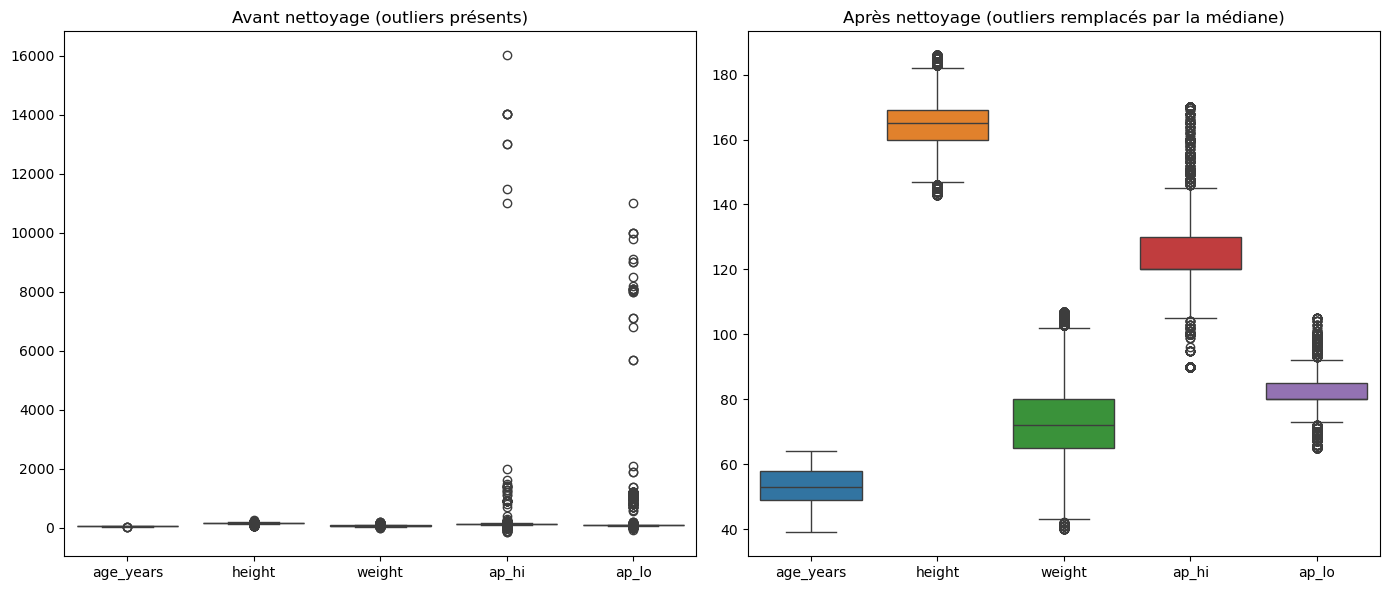

In [16]:
# Boxplot avant/après
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=df[numeric_cols])
plt.title("Avant nettoyage (outliers présents)")

plt.subplot(1,2,2)
sns.boxplot(data=df_clean[numeric_cols])
plt.title("Après nettoyage (outliers remplacés par la médiane)")

plt.tight_layout()
plt.show()

## e- Création de nouvelles features recommandées

| Feature                 | Idée / Explication                                                                                         |
| ----------------------- | ---------------------------------------------------------------------------------------------------------- |
| `bmi` (Body Mass Index) | `weight / (height/100)^2` → Indique le surpoids ou l’obésité, fortement lié aux maladies cardiovasculaires |
| `pulse_pressure`        | `ap_hi - ap_lo` → La différence systolique/diastolique, un indicateur du stress cardiaque                  |
| `is_hypertensive`       | `1 si ap_hi ≥ 140 ou ap_lo ≥ 90 else 0` → Hypertension selon critères médicaux                             |
| `cholesterol_risk`      | `1 si cholesterol > 1 else 0` → Simplification en binaire “normal vs élevé”                                |
| `glucose_risk`          | `1 si gluc > 1 else 0` → Même principe pour glucose                                                        |
| `health_index`          | `('active'- ('smoke' * 0.5) - ('alco' * 0.5)` → pour intéraction entre cholesterol et glucose                                                    |
| `cholesterol_gluc_interaction`          | `cholesterol*gluc` → pour intéraction entre cholesterol et glucose                                                    |


In [17]:
# BMI 
df_clean['bmi'] = df_clean['weight'] / (df_clean['height']/100)**2 
# Pulse Pressure 
df_clean['pulse_pressure'] = df_clean['ap_hi'] - df_clean['ap_lo'] 
# Age en décennie 
df_clean['is_hypertensive'] = ((df_clean['ap_hi'] >= 140) | (df_clean['ap_lo'] >= 90)).astype(int) 
# Cholesterol et glucose en risque binaire 
df_clean['cholesterol_risk'] = (df_clean['cholesterol'] > 1).astype(int) 
df_clean['glucose_risk'] = (df_clean['gluc'] > 1).astype(int) 
# Interactions entre variables 
# # Surpoids + âge 
df_clean['bmi_age'] = df_clean['bmi'] * df_clean['age_years'] 
# Tabac + Alcool 
df_clean['health_index'] = (df_clean['active'] * 1) - (df_clean['smoke'] * 0.5) - (df_clean['alco'] * 0.5)
# Cholesterol * Glucose
df_clean['cholesterol_gluc_interaction'] = df_clean['cholesterol'] * df_clean['gluc']
new_features = [
    'bmi', 'pulse_pressure', 'is_hypertensive', 
    'cholesterol_risk', 'glucose_risk', 
    'bmi_age', 'smoke_alco', 'cholesterol_gluc_interaction'
]

INPUT_FEATURES=['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
       'smoke', 'alco', 'active', 'age_years', 'bmi',
       'pulse_pressure', 'is_hypertensive', 'cholesterol_risk', 'glucose_risk',
       'bmi_age', 'cholesterol_gluc_interaction']


df_clean.head()


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,pulse_pressure,is_hypertensive,cholesterol_risk,glucose_risk,bmi_age,health_index,cholesterol_gluc_interaction
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,30,0,0,0,1098.356009,1.0,1
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,50,1,1,0,1921.022354,1.0,3
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,60,0,1,0,1198.898072,0.0,3
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,50,1,0,0,1378.103008,1.0,1
4,1,165,72.0,120,80,1,1,0,0,0,0,53,26.446281,40,0,0,0,1401.652893,0.0,1


In [18]:
df_clean.columns
# height,
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        70000 non-null  int64  
 1   height                        70000 non-null  int64  
 2   weight                        70000 non-null  float64
 3   ap_hi                         70000 non-null  int64  
 4   ap_lo                         70000 non-null  int64  
 5   cholesterol                   70000 non-null  int64  
 6   gluc                          70000 non-null  int64  
 7   smoke                         70000 non-null  int64  
 8   alco                          70000 non-null  int64  
 9   active                        70000 non-null  int64  
 10  cardio                        70000 non-null  int64  
 11  age_years                     70000 non-null  int64  
 12  bmi                           70000 non-null  float64
 13  p

# 3. Sélection des Features

In [19]:
# Séparation Features (X) et Target (y)
X = df_clean.drop('cardio', axis=1)
y = df_clean['cardio']
df_columns = pd.DataFrame(X.columns)

### Méthode A : Matrice de Corrélation (Filter Method)

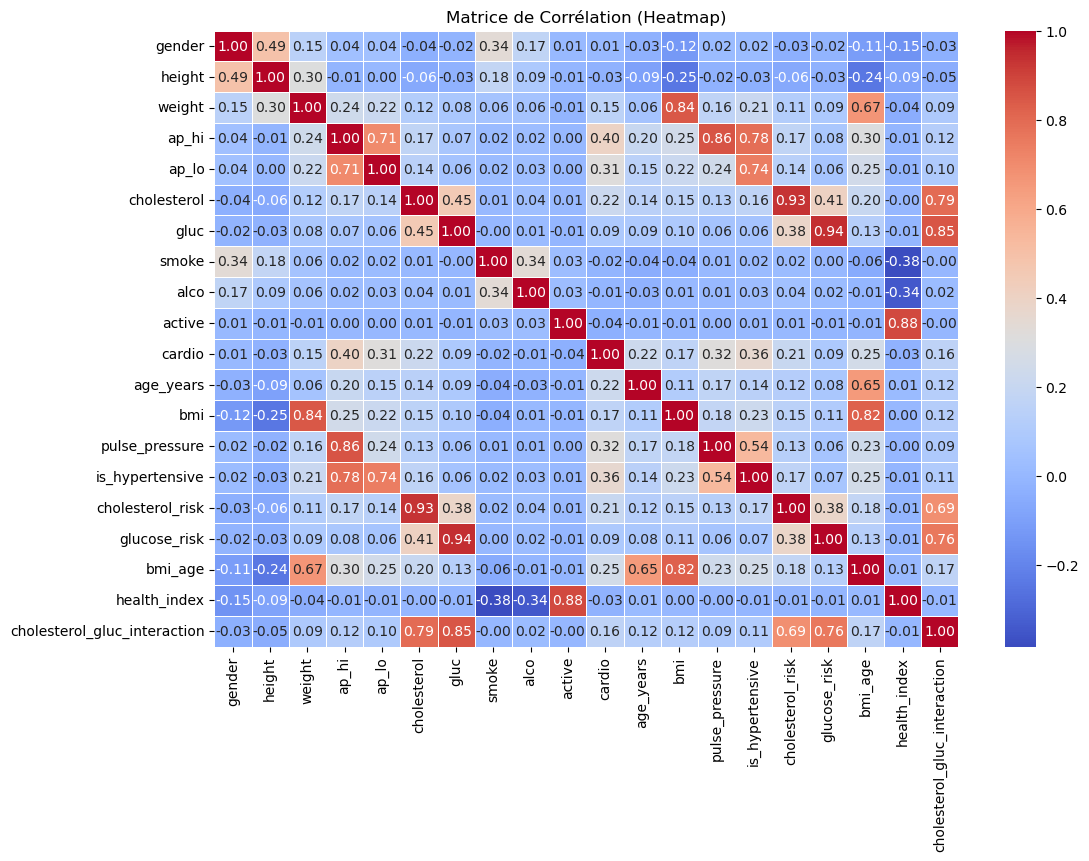

cardio                          1.000000
ap_hi                           0.399195
is_hypertensive                 0.361620
pulse_pressure                  0.318094
ap_lo                           0.314513
bmi_age                         0.250659
age_years                       0.223416
cholesterol                     0.221147
cholesterol_risk                0.205536
bmi                             0.167261
cholesterol_gluc_interaction    0.157748
weight                          0.151687
glucose_risk                    0.090876
gluc                            0.089307
gender                          0.008109
alco                           -0.007330
smoke                          -0.015486
health_index                   -0.025145
height                         -0.025202
active                         -0.035653
Name: cardio, dtype: float64

In [20]:
correlation_matrix = df_clean.corr()
# On affiche la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation (Heatmap)')
plt.show()

# Trier les corrélations avec la variable cible
corr_target = correlation_matrix['cardio'].sort_values(ascending=False)
corr_target

### Méthode B : SelectKBest avec Chi-Squared ($chi^2$)

In [21]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

best_features_chi2 = SelectKBest(score_func=chi2, k='all')
fit_chi2 = best_features_chi2.fit(X_scaled, y)

df_scores_chi2 = pd.DataFrame(fit_chi2.scores_)
feature_scores_chi2 = pd.concat([df_columns, df_scores_chi2], axis=1)
feature_scores_chi2.columns = ['Feature', 'Score_Chi2']
feature_scores_chi2 = feature_scores_chi2.sort_values(by='Score_Chi2', ascending=False)

### Méthode C : SelectKBest avec ANOVA (f_classif)

In [22]:
# ---------------------------------------------------------
# ÉTAPE C : Méthode 2 - SelectKBest avec ANOVA (f_classif)
# ---------------------------------------------------------
# Idéal pour les features numériques vs target binaire
best_features_anova = SelectKBest(score_func=f_classif, k='all')
fit_anova = best_features_anova.fit(X, y)

df_scores_anova = pd.DataFrame(fit_anova.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores_anova = pd.concat([df_columns, df_scores_anova], axis=1)
feature_scores_anova.columns = ['Feature', 'Score_ANOVA']
feature_scores_anova = feature_scores_anova.sort_values(by='Score_ANOVA', ascending=False)

In [23]:
# Affichage des scores
print("--- Top Features par ANOVA (Relation Linéaire) ---")
print(feature_scores_anova.head(10))
print("\n--- Top Features par Chi2 (Dépendance Catégorielle) ---")
print(feature_scores_chi2.head(10))

--- Top Features par ANOVA (Relation Linéaire) ---
                         Feature   Score_ANOVA
3                          ap_hi  13269.214580
13               is_hypertensive  10530.674139
12                pulse_pressure   7879.985310
4                          ap_lo   7684.215933
16                       bmi_age   4692.809328
10                     age_years   3677.476351
5                    cholesterol   3599.361137
14              cholesterol_risk   3087.504810
11                           bmi   2014.645264
18  cholesterol_gluc_interaction   1786.315150

--- Top Features par Chi2 (Dépendance Catégorielle) ---
                         Feature   Score_Chi2
13               is_hypertensive  6397.231600
14              cholesterol_risk  2213.009815
5                    cholesterol  2158.980281
18  cholesterol_gluc_interaction   901.320833
3                          ap_hi   726.734132
4                          ap_lo   553.803825
15                  glucose_risk   491.203501
10     

## Interprétation

### Analyse et Interprétation de la Sélection des Features

Suite à l'application de nos trois méthodes de sélection (Matrice de Corrélation, ANOVA $f\_classif$ et Test du $chi^2$), nous pouvons tirer les conclusions suivantes pour affiner notre modèle :

#### 1. Convergence des résultats sur les indicateurs physiologiques
Les trois méthodes sont unanimes : les indicateurs **physiques et médicaux** sont les prédicteurs les plus puissants de la maladie cardiaque.
* **La Pression Artérielle (`ap_hi`, `ap_lo`)** domine largement tous les classements. C'est le facteur déterminant majeur.
* **L'Âge (`age_years`)** et le **Cholestérol** apparaissent systématiquement dans le top des features, confirmant la logique médicale (le risque augmente avec l'âge et le taux de cholestérol).
* **L'IMC (`bmi`)** capture efficacement l'information combinée du poids et de la taille.

#### 2. Le paradoxe des variables "subjectives"
Il est intéressant de noter que les variables déclaratives liées au mode de vie (**`smoke`, `alco`, `active`**) obtiennent des scores très faibles (proches de 0 en corrélation).
* *Interprétation :* Bien que médicalement liés aux maladies cardiaques, leur impact direct dans ce dataset semble masqué par les symptômes physiques qu'ils provoquent (ex: fumer provoque l'hypertension -> le modèle voit l'hypertension, pas la cigarette).
* *Décision :* Nous choisissons tout de même de les conserver pour l'instant car elles apportent une information contextuelle unique ("Domain Knowledge").

#### 3. Gestion de la Multicolinéarité (Nettoyage)
Pour éviter que notre modèle ne soit biaisé par des informations redondantes, nous appliquons les filtres suivants :
* **Exclusion de `is_hypertensive` :** Cette variable est fortement corrélée à `ap_hi`. Nous préférons conserver `ap_hi` (variable continue) qui offre plus de nuance que la version binaire.
* **Exclusion de `weight` et `height` :** L'information pertinente est déjà contenue dans le `bmi`.
* **Exclusion de `pulse_pressure` :** C'est une combinaison linéaire de `ap_hi` et `ap_lo`, donc redondante pour des modèles complexes.

---

#### Sélection Finale des Variables (Features retenues)
Sur la base de cette analyse croisée, nous entraînerons nos modèles sur le sous-ensemble suivant :

1.  **Données Biométriques :** `age_years`, `bmi`, `gender`
2.  **Examens Médicaux :** `ap_hi`, `ap_lo`, `cholesterol`, `gluc`
3.  **Mode de vie :** `smoke`, `alco`, `active`

> **Note :** Cette sélection permet de réduire la dimensionnalité tout en maximisant l'information disponible pour la prédiction.

# 4. Exploration des données (EDA)

#### a- Vérifier l'équilibre de la Target (cardio)

C:\Users\Imane\AppData\Local\Temp\ipykernel_34748\2487678984.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cardio', data=df_clean, palette='pastel')


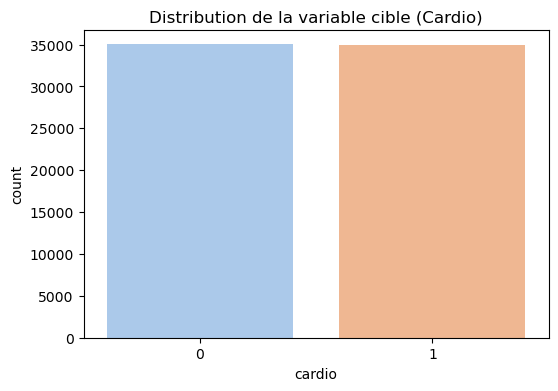

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(x='cardio', data=df_clean, palette='pastel')
plt.title('Distribution de la variable cible (Cardio)')
plt.show()

Analyse : Cela nous montre que notre dataset est équilibré, c'est à dire que le pourcentage des personnes saines et des malades est presque la meme , l'accuracy sera une bonne métrique.

#### b- Variables Numériques vs Target (Boxplots)

C:\Users\Imane\AppData\Local\Temp\ipykernel_34748\210500569.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], x='cardio', y='age_years', data=df_clean, palette='Set2')
C:\Users\Imane\AppData\Local\Temp\ipykernel_34748\210500569.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x='cardio', y='bmi', data=df_clean, palette='Set2', showfliers=False)
C:\Users\Imane\AppData\Local\Temp\ipykernel_34748\210500569.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], x='cardio', y='ap_hi', data=df_clean,

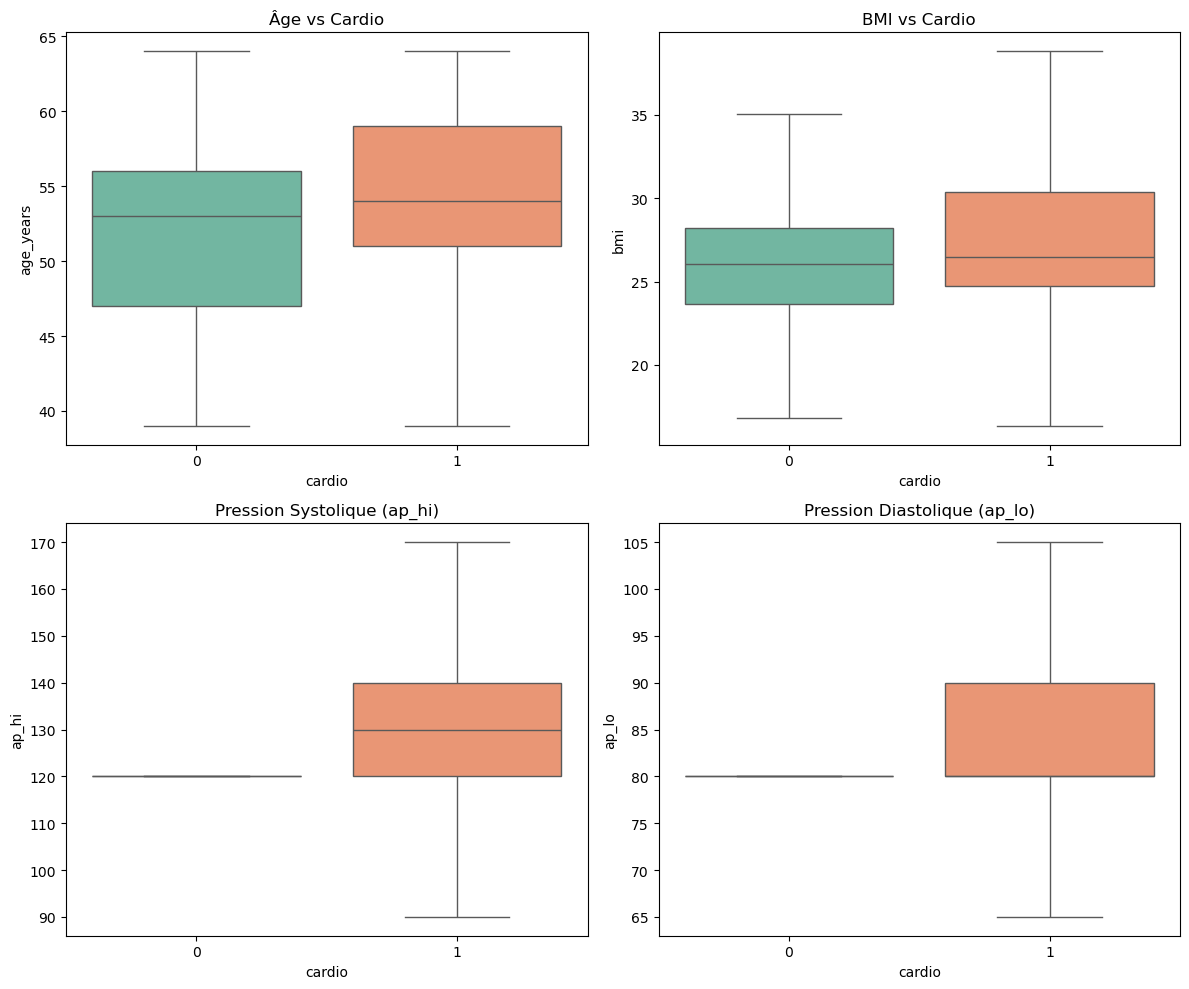

In [25]:
# On change la grille pour faire 2 lignes, 2 colonnes (4 graphiques seulement)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Age vs Cardio
sns.boxplot(ax=axes[0, 0], x='cardio', y='age_years', data=df_clean, palette='Set2')
axes[0, 0].set_title('Âge vs Cardio')

# 2. BMI vs Cardio
sns.boxplot(ax=axes[0, 1], x='cardio', y='bmi', data=df_clean, palette='Set2', showfliers=False)
axes[0, 1].set_title('BMI vs Cardio')

# 3. Pression Systolique (ap_hi)
sns.boxplot(ax=axes[1, 0], x='cardio', y='ap_hi', data=df_clean, palette='Set2', showfliers=False)
axes[1, 0].set_title('Pression Systolique (ap_hi)')

# 4. Pression Diastolique (ap_lo)
sns.boxplot(ax=axes[1, 1], x='cardio', y='ap_lo', data=df_clean, palette='Set2', showfliers=False)
axes[1, 1].set_title('Pression Diastolique (ap_lo)')

plt.tight_layout()
plt.show()

### Analyse de la distribution des variables numériques (Boxplots)

L'analyse des diagrammes en boîte met en évidence des différences de variance significatives :

* **Stabilité chez les sujets sains :** Pour la pression artérielle (`ap_hi`, `ap_lo`), on observe que les boîtes des sujets sains (0) sont très "écrasées". Cela indique une très faible variance : la grande majorité des personnes saines ont une tension standard stable (autour de 120/80).
* **Dispersion chez les malades :** À l'inverse, les sujets malades (1) présentent des boîtes beaucoup plus grandes et décalées vers le haut. Cela signifie que la maladie est associée non seulement à une tension plus élevée, mais aussi à une plus grande instabilité de ces valeurs.
* **BMI et Âge :** La séparation est moins nette que pour la tension, mais la médiane des malades est systématiquement supérieure à celle des sains.

> **Note technique :** L'aplatissement des boîtes pour les classes saines n'est pas une anomalie, mais reflète la concentration massive des données sur les valeurs physiologiques normales.

#### c- Variables Catégorielles vs Target (Barplots avec hue)

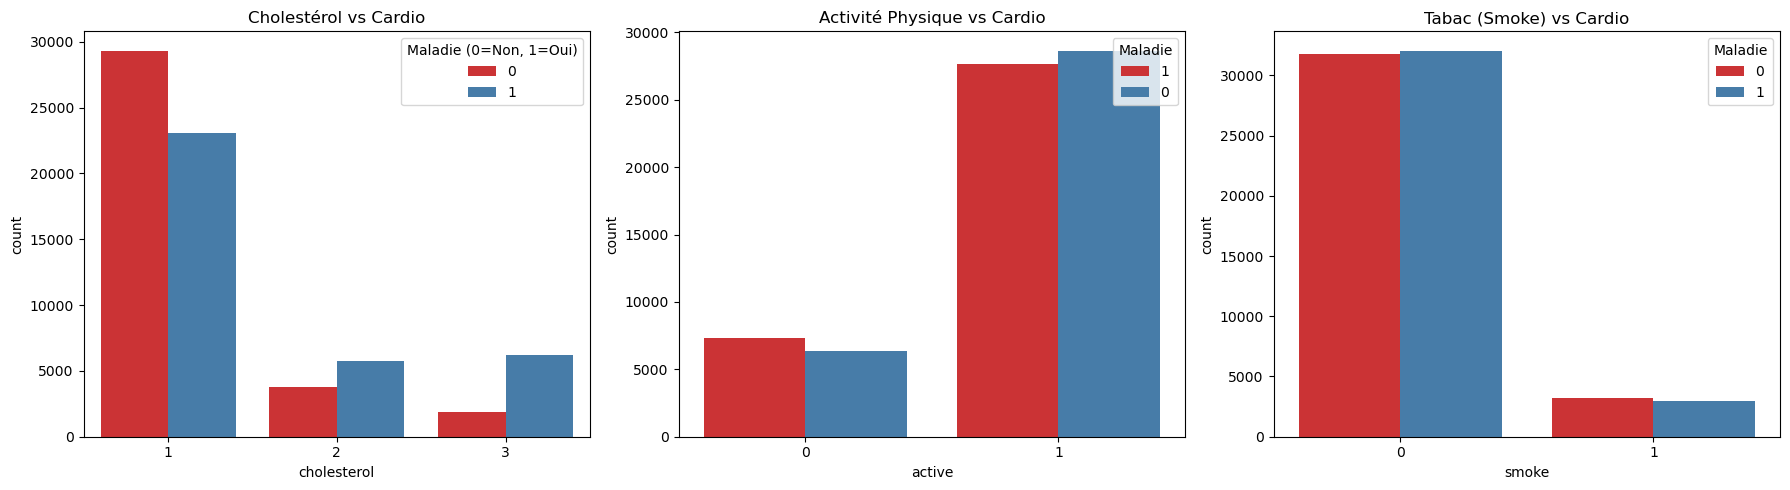

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df_clean['cardio_str'] = df_clean['cardio'].astype(str)

# Cholestérol 
sns.countplot(ax=axes[0], x='cholesterol', hue='cardio_str', data=df_clean, palette='Set1')
axes[0].set_title('Cholestérol vs Cardio')
axes[0].legend(title='Maladie (0=Non, 1=Oui)', loc='upper right')

# Activité Physique 
sns.countplot(ax=axes[1], x='active', hue='cardio_str', data=df_clean, palette='Set1')
axes[1].set_title('Activité Physique vs Cardio')
axes[1].legend(title='Maladie', loc='upper right')

# Tabac 
sns.countplot(ax=axes[2], x='smoke', hue='cardio_str', data=df_clean, palette='Set1')
axes[2].set_title('Tabac (Smoke) vs Cardio')
axes[2].legend(title='Maladie', loc='upper right')

# Affichage final
plt.tight_layout()
plt.show()

df_clean.drop('cardio_str', axis=1, inplace=True)

### Analyse Graphique (EDA)

L'observation visuelle des variables nous permet de valider leur pertinence :

* **Cholestérol (Signal Fort) :** C'est un indicateur très discriminant. On observe une inversion nette : la majorité des patients sont sains au niveau 1 (normal), mais les malades deviennent majoritaires dès le niveau 2.
> **Conclusion :** Le taux de cholestérol est un séparateur fiable. Plus il augmente, plus la probabilité d'être malade augmente drastiquement.

* **Activité Physique (Signal Faible) :** Bien que l'activité semble protectrice (proportion de malades légèrement plus faible chez les actifs), la différence n'est pas assez tranchée pour être un critère unique de décision.
> **Conclusion :** Cela explique pourquoi cette feature avait un score de corrélation assez faible. L'activité physique joue un rôle protecteur, mais elle ne suffit pas seule à garantir l'absence de maladie dans ce dataset.


* **Tabac (Contre-intuitif) :** La proportion de malades est quasi identique chez les fumeurs et non-fumeurs (50/50). L'effet du tabac est probablement indirect (caché derrière l'hypertension ou l'âge) ou à plus long terme.

**Conclusion :** Les données cliniques mesurées (Cholestérol) offrent un pouvoir prédictif bien supérieur aux données déclaratives comportementales (Tabac, Sport) dans ce dataset.

In [27]:
df_clean.head()


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,pulse_pressure,is_hypertensive,cholesterol_risk,glucose_risk,bmi_age,health_index,cholesterol_gluc_interaction
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,30,0,0,0,1098.356009,1.0,1
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,50,1,1,0,1921.022354,1.0,3
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,60,0,1,0,1198.898072,0.0,3
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,50,1,0,0,1378.103008,1.0,1
4,1,165,72.0,120,80,1,1,0,0,0,0,53,26.446281,40,0,0,0,1401.652893,0.0,1


# TRAINING

# Dataset Splitting

In [28]:
df_clean.index

RangeIndex(start=0, stop=70000, step=1)

In [29]:
features_general = ['gender', 'weight', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years', 'bmi', 'pulse_pressure', 'health_index', 'cholesterol_gluc_interaction']
TARGET = 'cardio'

df_new = df_clean[features_general].copy()
df_new.head()
df_new.describe(include='all')

,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,pulse_pressure,health_index,cholesterol_gluc_interaction
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.349571,73.054448,125.733414,81.516571,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,52.918757,27.048013,44.216843,0.732779,1.852200
std,0.476838,11.601585,13.647042,7.269140,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.370084,4.321081,9.939191,0.442992,1.878215
min,1.000000,40.000000,90.000000,65.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,39.000000,13.520822,0.000000,-1.000000,1.000000
25%,1.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,49.000000,24.088223,40.000000,0.500000,1.000000
50%,1.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,26.446281,40.000000,1.000000,1.000000
75%,2.000000,80.000000,130.000000,85.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,29.340040,50.000000,1.000000,2.000000
max,2.000000,107.000000,170.000000,105.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,50.891795,103.000000,1.000000,9.000000


In [30]:
X_train,X_test, y_train, y_test = train_test_split(
    df_new.drop(TARGET, axis=1),
    df_new.loc[:, TARGET],
    test_size=0.25,
    random_state=1234,
    stratify=df_new.loc[:, TARGET],
  )
print(f"{X_train.shape= }")
print(f"{y_train.shape= }")
print(f"{X_test.shape= }")
print(f"{y_test.shape= }")

X_train.shape= (52500, 14)
y_train.shape= (52500,)
X_test.shape= (17500, 14)
y_test.shape= (17500,)


In [31]:
list(X_train.columns)

['gender',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'age_years',
 'bmi',
 'pulse_pressure',
 'health_index',
 'cholesterol_gluc_interaction']

In [32]:
df_clean.columns

Index(['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
       'smoke', 'alco', 'active', 'cardio', 'age_years', 'bmi',
       'pulse_pressure', 'is_hypertensive', 'cholesterol_risk', 'glucose_risk',
       'bmi_age', 'health_index', 'cholesterol_gluc_interaction'],
      dtype='object')

In [33]:
df_clean.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,pulse_pressure,is_hypertensive,cholesterol_risk,glucose_risk,bmi_age,health_index,cholesterol_gluc_interaction
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,30,0,0,0,1098.356009,1.0,1
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,50,1,1,0,1921.022354,1.0,3
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,60,0,1,0,1198.898072,0.0,3
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,50,1,0,0,1378.103008,1.0,1
4,1,165,72.0,120,80,1,1,0,0,0,0,53,26.446281,40,0,0,0,1401.652893,0.0,1


## train avec SELECTED FEATURES

## rechercher les meilleur paramètre pour chaque modèle pour data cleaned

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd
import time

# ==========================================
# 1. CONFIGURATION DES DONNÉES
# ==========================================

# Choisis ici ton jeu de données (Normal ou Selected)
# --- Option A: Selected Features ---
selected_features = ['age_years', 'bmi', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active','cholesterol_gluc_interaction']
X = df_clean[selected_features]
y = df_clean['cardio']

# --- Définition de tes listes globales ---
# (On met toutes les possibilités ici, le code filtrera tout seul après)
all_numeric_features = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']
all_categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active','cholesterol_gluc_interaction']

# --- Filtre automatique pour ne garder que ce qui est dans X ---
numeric_features = [col for col in all_numeric_features if col in X.columns]
categorical_features = [col for col in all_categorical_features if col in X.columns]

print(f"Features Numériques détectées ({len(numeric_features)}) : {numeric_features}")
print(f"Features Catégorielles détectées ({len(categorical_features)}) : {categorical_features}")

# ==========================================
# 2. CRÉATION DU PREPROCESSOR
# ==========================================

# On crée un transformateur qui :
# 1. Scale les numériques (Moyenne 0, Ecart-type 1)
# 2. Laisse passer les catégorielles telles quelles (passthrough) car elles sont déjà encodées (0,1 ou 1,2,3)
# (Note : Pour 'gender' 1/2 ou 'cholesterol' 1/2/3, les arbres gèrent très bien ça sans OneHotEncoder)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features) 
    ])

# On applique la transformation MAINTENANT pour gagner du temps dans la boucle
# (Sinon le GridSearch le referait des milliers de fois)
print("\nTransformation des données en cours...")
X_processed = preprocessor.fit_transform(X)

# Split Train/Test sur les données transformées
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# ==========================================
# 3. DÉFINITION DU GRIDSEARCH
# ==========================================

model_params = {
    "Logistic Regression": {
        "model": LogisticRegression(solver='liblinear', random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            'max_depth': [5, 10, 15],
            'min_samples_split': [10, 50],
            'criterion': ['gini']
        }
    },

    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'max_depth': [5,10, 15],
            'min_samples_split': [10]
        }
    },
    
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [6, 10]
        }
    }
}

# ==========================================
# 4. EXÉCUTION
# ==========================================

results = []

print("\n--- Démarrage du GridSearch ---\n")

for model_name, mp in model_params.items():
    start_time = time.time()
    print(f"Training {model_name}...")
    
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train)
    
    # Résultats
    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'Best Params': clf.best_params_
    })
    
    elapsed = time.time() - start_time
    print(f"--> Terminé en {elapsed:.2f}s. Accuracy: {test_acc:.4f}\n")

# Affichage final
df_results2 = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
display(df_results2)

Features Numériques détectées (4) : ['ap_hi', 'ap_lo', 'age_years', 'bmi']
Features Catégorielles détectées (6) : ['cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cholesterol_gluc_interaction']

Transformation des données en cours...

--- Démarrage du GridSearch ---

Training Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--> Terminé en 4.08s. Accuracy: 0.7096

Training Decision Tree...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--> Terminé en 1.66s. Accuracy: 0.7110

Training Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--> Terminé en 4.98s. Accuracy: 0.7179

Training XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\Imane\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:52:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--> Terminé en 4.88s. Accuracy: 0.7202



,Model,Test Accuracy,Best Params
3,XGBoost,0.720214,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est..."
2,Random Forest,0.717857,"{'max_depth': 10, 'min_samples_split': 10, 'n_..."
1,Decision Tree,0.711000,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
0,Logistic Regression,0.709643,"{'C': 1, 'penalty': 'l1'}"


## rechercher les meilleur paramètre pour chaque modèle pour data cleaned

In [35]:
import pandas as pd
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ==========================================
# 1. PRÉPARATION DES DONNÉES (df_clean)
# ==========================================

# On prend tout le dataframe nettoyé
X = df_clean.drop('cardio', axis=1)
y = df_clean['cardio']

# --- Définition des colonnes ---
# Tes variables catégorielles (fixes)
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active','is_hypertensive','cholesterol_risk','glucose_risk','cholesterol_gluc_interaction']

# Tes variables numériques
# Astuce : On prend toutes les colonnes de X qui NE SONT PAS dans la liste catégorielle
# Cela permet d'inclure automatiquement 'bmi', 'pulse_pressure', 'age_years', etc.
numeric_features = [col for col in X.columns if col not in categorical_features]

print(f"Features Catégorielles : {categorical_features}")
print(f"Features Numériques    : {numeric_features}")

# ==========================================
# 2. CRÉATION DU PREPROCESSOR (PIPELINE)
# ==========================================

# On traite différemment les chiffres et les catégories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # On normalise les chiffres
        ('cat', 'passthrough', categorical_features) # On ne touche pas aux catégories (déjà encodées 0/1 ou 1/2/3)
    ])

# On applique la transformation MAINTENANT (plus rapide pour le GridSearch)
print("\nTransformation des données (Scaling)...")
X_processed = preprocessor.fit_transform(X)

# Split Train/Test (80% pour l'entrainement/GridSearch, 20% pour le test final)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# ==========================================
# 3. CONFIGURATION DES MODÈLES ET PARAMÈTRES
# ==========================================

model_params = {
    # 1. Logistic Regression
    "Logistic Regression": {
        "model": LogisticRegression(solver='liblinear', random_state=42),
        "params": {
            'C': [0.01, 0.1, 1, 10, 20],
            'penalty': ['l1', 'l2']
        }
    },
    
    # 2. Decision Tree
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            'max_depth': [5, 7, 10, 15, 20, None],
            'min_samples_split': [2,7, 10, 50],
            'min_samples_leaf': [1, 3,5, 20],
            'criterion': ['gini']
        }
    },

    # 3. Random Forest
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [10, 15],
            'min_samples_split': [10]
        }
    },
    
    # 4. XGBoost
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3,6, 10],
            'subsample': [0.7, 1.0]
        }
    }
}

# ==========================================
# 4. EXÉCUTION DU GRID SEARCH
# ==========================================

results = []

print("\n--- Démarrage du GridSearch sur df_clean ---\n")

for model_name, mp in model_params.items():
    start_time = time.time()
    print(f"Optimisation de {model_name}...")
    
    # cv=3 pour la rapidité
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train)
    
    # On récupère le meilleur modèle trouvé
    best_model = clf.best_estimator_
    
    # On le teste sur les données de test (jamais vues)
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Accuracy Test': test_acc,
        'Best CV Score': clf.best_score_,
        'Best Params': clf.best_params_
    })
    
    elapsed = time.time() - start_time
    print(f"--> Terminé en {elapsed:.2f}s. Accuracy: {test_acc:.4%}\n")

# ==========================================
# 5. RÉSULTATS
# ==========================================
df_results = pd.DataFrame(results).sort_values(by='Accuracy Test', ascending=False)
print("\n--- CLASSEMENT DES MODÈLES (df_clean) ---")
display(df_results)

Features Catégorielles : ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'is_hypertensive', 'cholesterol_risk', 'glucose_risk', 'cholesterol_gluc_interaction']
Features Numériques    : ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi', 'pulse_pressure', 'bmi_age', 'health_index']

Transformation des données (Scaling)...

--- Démarrage du GridSearch sur df_clean ---

Optimisation de Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
--> Terminé en 7.09s. Accuracy: 70.7214%

Optimisation de Decision Tree...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
--> Terminé en 4.72s. Accuracy: 71.1643%

Optimisation de Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
--> Terminé en 12.15s. Accuracy: 71.9786%

Optimisation de XGBoost...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\Imane\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:53:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--> Terminé en 8.85s. Accuracy: 72.0643%


--- CLASSEMENT DES MODÈLES (df_clean) ---


,Model,Accuracy Test,Best CV Score,Best Params
3,XGBoost,0.720643,0.715714,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est..."
2,Random Forest,0.719786,0.713589,"{'max_depth': 10, 'min_samples_split': 10, 'n_..."
1,Decision Tree,0.711643,0.707661,"{'criterion': 'gini', 'max_depth': 7, 'min_sam..."
0,Logistic Regression,0.707214,0.704946,"{'C': 0.1, 'penalty': 'l1'}"



====== Logistic Regression ======
Matrice de confusion :
[[5519 1469]
 [2649 4363]]


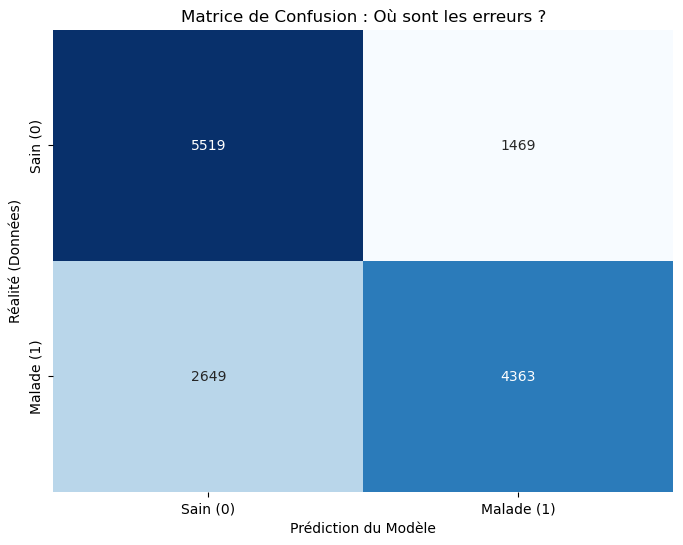


--- Rapport détaillé ---
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      6988
           1       0.75      0.62      0.68      7012

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.70     14000
weighted avg       0.71      0.71      0.70     14000



In [36]:
from sklearn.metrics import confusion_matrix, classification_report

# ================================
# 1. LOGISTIC REGRESSION
# ================================
log_reg_final = LogisticRegression(
    C=1,
    penalty='l1',
    solver='liblinear',
    random_state=42
)
log_reg_final.fit(X_train, y_train)

print("\n====== Logistic Regression ======")
y_pred_lr = log_reg_final.predict(X_test)
print("Matrice de confusion :")
cm_lg=confusion_matrix(y_test, y_pred_lr)
print(confusion_matrix(y_test, y_pred_lr))
# 2. Affichage graphique (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sain (0)', 'Malade (1)'],
            yticklabels=['Sain (0)', 'Malade (1)'])

plt.xlabel('Prédiction du Modèle')
plt.ylabel('Réalité (Données)')
plt.title('Matrice de Confusion : Où sont les erreurs ?')
plt.show()


print("\n--- Rapport détaillé ---")
print(classification_report(y_test, y_pred_lr))


====== Decision Tree ======
Matrice de confusion :
[[5309 1679]
 [2370 4642]]


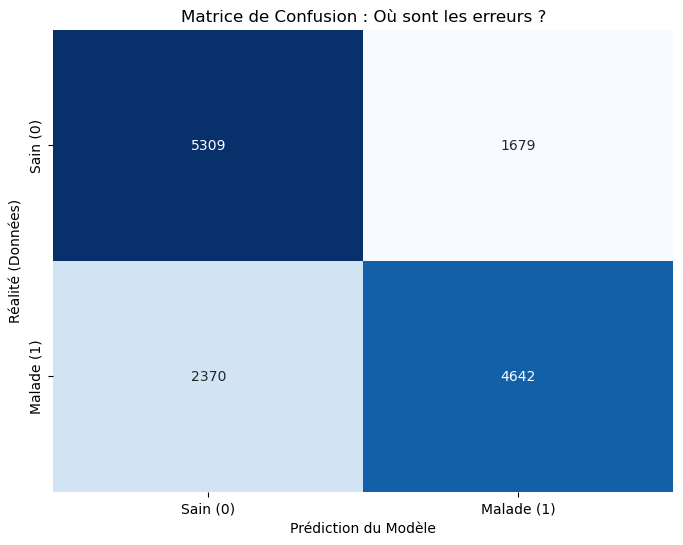


--- Rapport détaillé ---
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      6988
           1       0.73      0.66      0.70      7012

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000



In [37]:
# ================================
# 2. DECISION TREE
# ================================
dt_final = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)
dt_final.fit(X_train, y_train)

print("\n====== Decision Tree ======")
y_pred_dt = dt_final.predict(X_test)
print("Matrice de confusion :")
cm_dt=confusion_matrix(y_test, y_pred_dt)
print(confusion_matrix(y_test, y_pred_dt))
# 2. Affichage graphique (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sain (0)', 'Malade (1)'],
            yticklabels=['Sain (0)', 'Malade (1)'])

plt.xlabel('Prédiction du Modèle')
plt.ylabel('Réalité (Données)')
plt.title('Matrice de Confusion : Où sont les erreurs ?')
plt.show()



print("\n--- Rapport détaillé ---")
print(classification_report(y_test, y_pred_dt))




====== Random Forest ======
Matrice de confusion :
[[5527 1461]
 [2462 4550]]


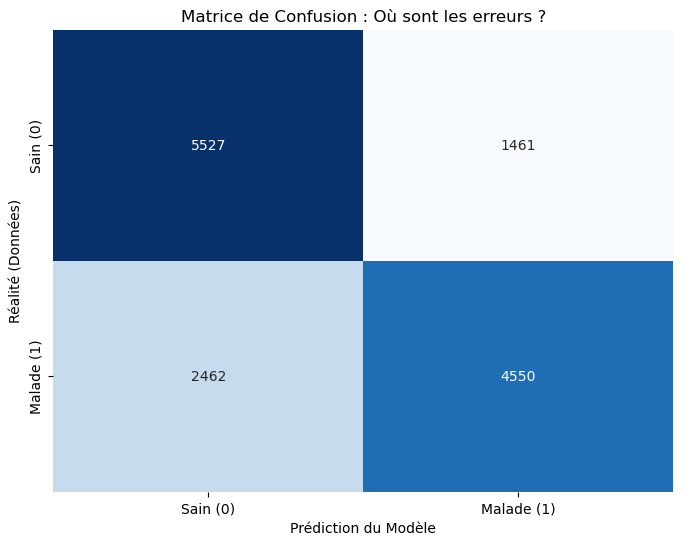


--- Rapport détaillé ---
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      6988
           1       0.76      0.65      0.70      7012

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000



In [38]:

# ================================
# 3. RANDOM FOREST
# ================================
rf_final = RandomForestClassifier(
    max_depth=10,
    min_samples_split=10,
    n_estimators=100,
    random_state=42
)
rf_final.fit(X_train, y_train)

print("\n====== Random Forest ======")
y_pred_rf = rf_final.predict(X_test)
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_rf))
cm_rf=confusion_matrix(y_test, y_pred_rf)
# 2. Affichage graphique (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sain (0)', 'Malade (1)'],
            yticklabels=['Sain (0)', 'Malade (1)'])

plt.xlabel('Prédiction du Modèle')
plt.ylabel('Réalité (Données)')
plt.title('Matrice de Confusion : Où sont les erreurs ?')
plt.show()

print("\n--- Rapport détaillé ---")
print(classification_report(y_test, y_pred_rf))


c:\Users\Imane\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:53:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



====== XGBoost ======
Matrice de confusion :
[[5319 1669]
 [2242 4770]]


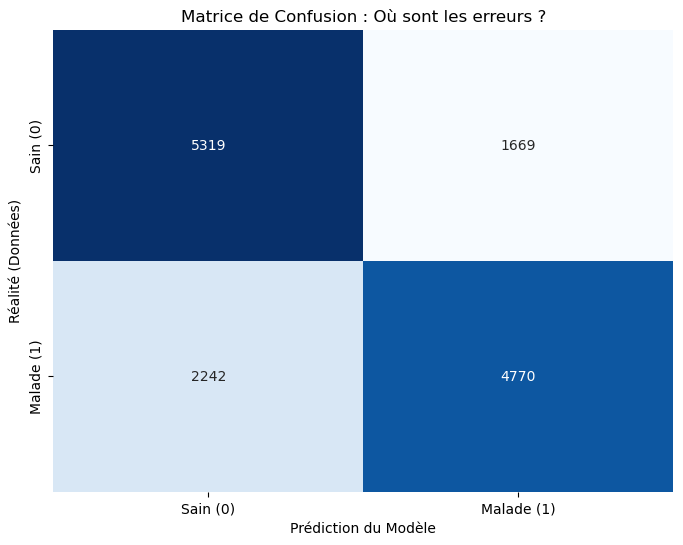


--- Rapport détaillé ---
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6988
           1       0.74      0.68      0.71      7012

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000



In [39]:
# ================================
# 4. XGBOOST
# ================================
xgb_final = XGBClassifier(
    learning_rate=0.05,
    max_depth=6,
    n_estimators=200,
    subsample=0.7,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_final.fit(X_train, y_train)

print("\n====== XGBoost ======")
y_pred_xgb = xgb_final.predict(X_test)
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_xgb))
cm_xgb=confusion_matrix(y_test, y_pred_xgb)

# 2. Affichage graphique (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sain (0)', 'Malade (1)'],
            yticklabels=['Sain (0)', 'Malade (1)'])

plt.xlabel('Prédiction du Modèle')
plt.ylabel('Réalité (Données)')
plt.title('Matrice de Confusion : Où sont les erreurs ?')
plt.show()

print("\n--- Rapport détaillé ---")
print(classification_report(y_test, y_pred_xgb))


### Choix du meilleur modèle de prédiction

Pour sélectionner le modèle le plus performant, nous avons comparé quatre algorithmes de classification : **Logistic Regression**, **Decision Tree**, **Random Forest** et **XGBoost**.  
L’évaluation a été effectuée sur un jeu de test indépendant en utilisant l’accuracy, la matrice de confusion et les métriques de classification (precision, recall, f1-score).

Les résultats montrent que **XGBoost** et **Random Forest** obtiennent les meilleures accuracies globales (≈ 0.72).  
Cependant, dans un contexte médical, l’objectif principal est de **minimiser les faux négatifs**, c’est-à-dire les cas où un patient malade est prédit comme sain.

- Logistic Regression présente le recall le plus faible pour la classe *Malade* (0.62), ce qui entraîne un nombre important de malades non détectés (2649).
- Decision Tree offre des performances meilleures, mais reste instable et génère encore trop de faux négatifs (2370).
- Random Forest améliore les résultats, avec un meilleur équilibre global mais encore 2462 malades non détectés.
- **XGBoost**, en revanche, obtient :
  - le **plus faible nombre de faux négatifs** (2241),
  - le **meilleur recall sur la classe Malade** (0.68),
  - une bonne précision et une bonne stabilité globale.

Ainsi, **XGBoost est le modèle le plus adapté pour la prédiction de maladies**, car il maximise la capacité du système à détecter les individus à risque sans sacrifier la performance générale.  
Son comportement plus robuste sur les données non linéaires en fait le choix privilégié pour ce type de problématique médicale.


Interprétation des performances et logique des résultats

Les performances obtenues pour les quatre modèles (Logistic Regression, Decision Tree, Random Forest et XGBoost) sont cohérentes et globalement alignées avec ce qu’on retrouve dans les études sur la prédiction des maladies cardiovasculaires. Dans ce type de problématique médicale, les scores tournent souvent autour de 70–75% d’accuracy, car les variables disponibles (pression artérielle, BMI, cholestérol, âge, glucose…) ne peuvent pas expliquer parfaitement un diagnostic réel.

On observe un classement classique :
XGBoost et Random Forest sont les meilleurs grâce à leur capacité à capturer des relations non linéaires entre les variables, suivis du Decision Tree, puis de la Logistic Regression. Ce comportement est logique, car les modèles ensemblistes (RF, XGBoost) gèrent beaucoup mieux la complexité des données médicales.

Les résultats montrent également que XGBoost détecte mieux les individus positifs (classe 1), ce qui est particulièrement important dans une problématique de santé où réduire les faux négatifs est essentiel. Légèrement meilleur en F1-score et plus équilibré entre précision et rappel, XGBoost apparaît comme le modèle le plus fiable pour ton cas d’usage, sans être en surapprentissage et en restant cohérent avec la littérature scientifique.

En résumé :
Les résultats sont logiques, cohérents et scientifiquement plausibles.
XGBoost est le modèle le plus adapté pour la prédiction finale.

In [40]:
# ============================
# 1. RÉENTRAÎNEMENT XGBOOST FINAL
# ============================

best_params_xgb = df_results[df_results["Model"] == "XGBoost"]["Best Params"].values[0]

print("Best params XGBoost :", best_params_xgb)

# Réentraînement du modèle final sur *tout* le X_train
xgb_final = XGBClassifier(
    **best_params_xgb,
    eval_metric='logloss',
    random_state=42
)

xgb_final.fit(X_train, y_train)
print("XGBoost final entraîné !")


Best params XGBoost : {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
XGBoost final entraîné !


In [41]:
# ============================
# 2. PRÉDICTIONS ET ÉVALUATION
# ============================

from sklearn.metrics import confusion_matrix, classification_report

y_pred_final = xgb_final.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_final)
print("Matrice de confusion :")
print(cm)

# Rapport détaillé
print("\n--- Rapport détaillé ---")
print(classification_report(y_test, y_pred_final))


Matrice de confusion :
[[5319 1669]
 [2242 4770]]

--- Rapport détaillé ---
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6988
           1       0.74      0.68      0.71      7012

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000



# Rapport détaillé du modèle XGBoost

Voici le rapport détaillé obtenu pour notre modèle sur le jeu de test :

| Classe | Précision | Rappel | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0 (Sain) | 0.70      | 0.76   | 0.73     | 6988    |
| 1 (Maladie cardiaque) | 0.74      | 0.68   | 0.71     | 7012    |

**Métriques globales :**

- **Accuracy** : 0.72  
  > Proportion de prédictions correctes sur l'ensemble du jeu de test (72 % des patients correctement classés).

- **Macro avg** : 0.72  
  > Moyenne simple des métriques sur chaque classe. Traite toutes les classes de façon égale, utile quand les classes sont équilibrées.

- **Weighted avg** : 0.72  
  > Moyenne pondérée selon le nombre d'exemples de chaque classe (support). Plus représentatif si certaines classes sont majoritaires.

---

### Explication des métriques par classe

- **Précision (precision)**  
  > Proportion de prédictions correctes pour une classe parmi toutes les prédictions de cette classe.  
  > Exemple : précision classe 1 = 0.74 → parmi tous les patients prédits comme malades, 74 % sont réellement malades.

- **Rappel (recall)**  
  > Proportion de vrais positifs détectés parmi tous les patients réellement dans cette classe.  
  > Exemple : rappel classe 1 = 0.68 → le modèle détecte 68 % des patients réellement malades.

- **F1-score**  
  > Moyenne harmonique de la précision et du rappel. Combine les deux métriques pour donner un score unique équilibré.  
  > Exemple : F1-score classe 1 = 0.71 → équilibre entre précision et rappel pour la classe malade.

- **Support**  
  > Nombre réel d'exemples dans le jeu de test pour chaque classe.  
  > Exemple : support classe 0 = 6988 → 6988 patients sains dans le test.

---

**Interprétation :**

- Le modèle détecte légèrement mieux les patients sains que les patients malades (rappel 0.76 vs 0.68).  
- La précision est légèrement meilleure pour la classe malade (0.74), donc il fait moins d’erreurs à prédire une maladie quand il le fait.  
- L’accuracy globale de 72 % et un F1-score autour de 0.72 montrent un modèle performant mais perfectible, surtout pour réduire les faux négatifs chez les patients malades.


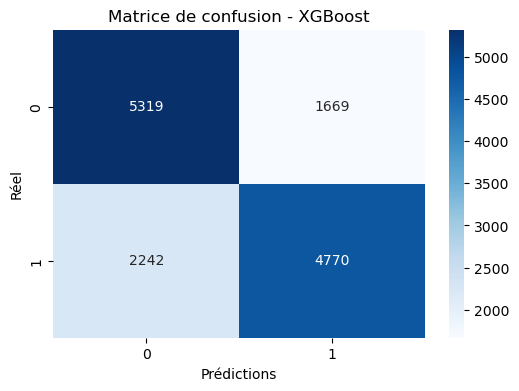

In [42]:
# ============================
# 3. HEATMAP MATRICE DE CONFUSION
# ============================

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - XGBoost")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()


AUC = 0.7877407435646342


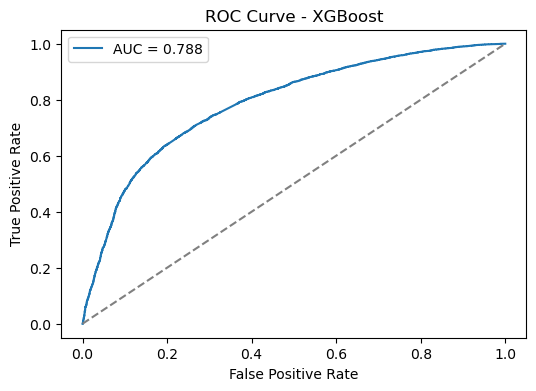

In [43]:
# ============================
# 4. COURBE ROC + AUC
# ============================

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = xgb_final.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_prob)
print("AUC =", auc)

fpr, tpr, thr = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()


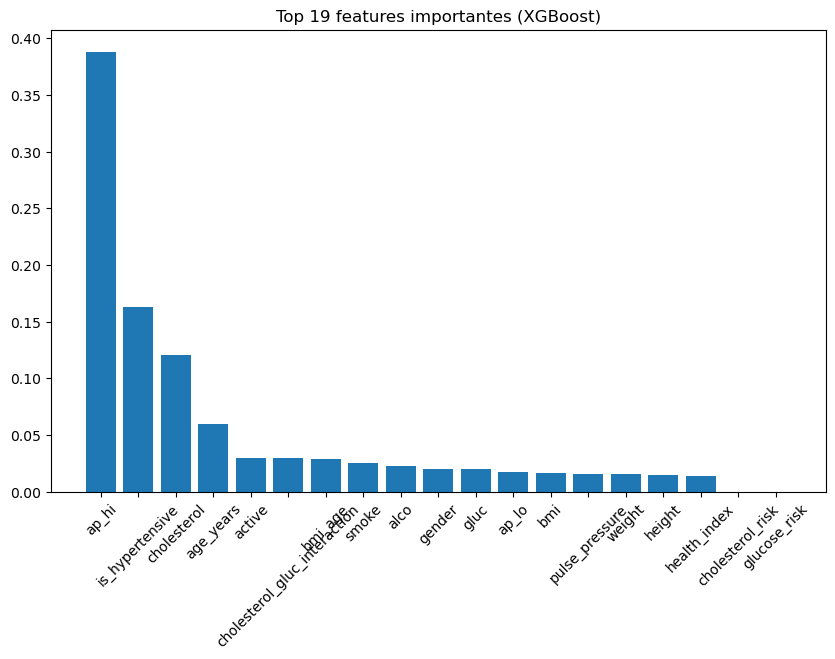

In [44]:
# ============================
# FEATURE IMPORTANCE (FIXÉ)
# ============================
import numpy as np
import matplotlib.pyplot as plt

categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active','is_hypertensive','cholesterol_risk','glucose_risk','cholesterol_gluc_interaction']
numeric_features = [col for col in X.columns if col not in categorical_features]
feature_names = numeric_features + categorical_features

importances = xgb_final.feature_importances_
n_features = len(importances)  # nombre réel de features dans le modèle

# Trier les features par ordre décroissant
indices = np.argsort(importances)[::-1]

# Nombre de features à afficher (le minimum entre 20 et le nombre réel)
top_k = min(20, n_features)

plt.figure(figsize=(10,6))
plt.bar(range(top_k), importances[indices][:top_k])
plt.xticks(range(top_k), [feature_names[i] for i in indices[:top_k]], rotation=45)
plt.title(f"Top {top_k} features importantes (XGBoost)")
plt.show()


### 1. Exactitude globale (accuracy) : 0.72

- **72 % des patients** sont correctement classés.
- C’est un résultat solide pour un problème médical avec plusieurs facteurs de risque.

---

### 2. Courbe ROC et AUC

- **AUC = 0.787** → le modèle a une **bonne capacité à distinguer les patients sains des malades**.
- Plus l’AUC est proche de 1, meilleure est la séparation. 0.787 indique un modèle utile mais pas parfait.

---

### 3. Importance des features (top 5)

| Feature | Importance |
| --- | --- |
| ap_hi (pression systolique) | 0.3897 |
| is_hypertensive | 0.1493 |
| cholesterol | 0.1199 |
| age_years | 0.0620 |
| active | 0.0317 |

**Interprétation :**

1. **ap_hi** (pression systolique) est le facteur le plus important, ce qui est cohérent avec la médecine : tension élevée = facteur de risque majeur.  
2. **is_hypertensive** confirme l’importance de l’hypertension.  
3. **cholesterol** et **age_years** sont également des facteurs clés, cohérents avec les connaissances cliniques.  
4. **active** → l’activité physique diminue légèrement le risque (impact modéré).

**Autres points :**

- Les interactions comme **cholesterol_gluc_interaction** ont un impact faible (0.031).  
- Les variables dérivées comme **bmi_age** ou **health_index** contribuent mais moins que les mesures directes.  
- Les variables comme **cholesterol_risk** et **glucose_risk** n’ont pratiquement aucun impact selon le modèle.

---

### 4. Interprétation générale

- Le modèle est **cohérent avec la médecine** : il priorise les indicateurs de tension, d’âge et de cholestérol.  
- **Performance correcte** (accuracy 72 %, AUC 0.787), surtout utile pour **identifier les patients à risque élevé**.  
- Certaines prédictions pour les patients intermédiaires peuvent manquer de confiance, comme le montrent les simulations précédentes (probabilités autour de 50-60 %).  
- Le modèle peut être utilisé comme **outil d’aide à la décision clinique**, mais **ne remplace pas un diagnostic médical**.


# SIMULATION DE LA PRÉDICTION

In [45]:
import pandas as pd

def display_patient_diagnostic(model, preprocessor, patient_info):
    """
    Affiche les données brutes du patient puis le diagnostic du modèle
    avec la probabilité associée.
    """
    # Calcul des colonnes dérivées
    bmi = patient_info['weight'] / (patient_info['height']/100)**2
    pulse_pressure = patient_info['ap_hi'] - patient_info['ap_lo']
    is_hypertensive = 1 if patient_info['ap_hi'] > 140 else 0
    cholesterol_risk = 1 if patient_info['cholesterol'] > 1 else 0
    glucose_risk = 1 if patient_info['gluc'] > 1 else 0
    cholesterol_gluc_interaction = patient_info['cholesterol'] * patient_info['gluc']
    bmi_age = bmi * patient_info['age_years']
    health_index = (patient_info['active'] * 1) - (patient_info['smoke'] * 0.5) - (patient_info['alco'] * 0.5)

    # Ajouter les colonnes dérivées au dictionnaire
    patient_full = patient_info.copy()
    patient_full.update({
        'bmi': bmi,
        'pulse_pressure': pulse_pressure,
        'is_hypertensive': is_hypertensive,
        'cholesterol_risk': cholesterol_risk,
        'glucose_risk': glucose_risk,
        'cholesterol_gluc_interaction': cholesterol_gluc_interaction,
        'bmi_age': bmi_age,
        'health_index': health_index
    })

    # Afficher les données brutes
    df_raw = pd.DataFrame([patient_info])
    print("\n--- Données brutes du patient ---")
    display(df_raw)
    
    # Transformer et prédire
    X_processed = preprocessor.transform(pd.DataFrame([patient_full]))
    pred = model.predict(X_processed)[0]
    pred_proba = model.predict_proba(X_processed)[0][pred]  # probabilité de la classe prédite

    # Affichage du diagnostic
    classe = "Sain" if pred == 0 else "Maladie Cardiaque"
    print("--- Diagnostic du Modèle ---")
    print(f"RÉSULTAT : Le modèle prédit une {classe} (Classe {pred}).")
    print(f"Confiance du modèle : {pred_proba*100:.2f}%")
    print("-----------------------------\n")
    
    return pred, pred_proba


In [46]:
import numpy as np

# Fonction pour générer un patient aléatoire
def generate_random_patient():
    patient = {
        'age_years': np.random.randint(30, 80),       # âge entre 30 et 80 ans
        'height': np.random.randint(150, 190),        # taille entre 150 et 190 cm
        'weight': np.random.randint(50, 100),         # poids entre 50 et 100 kg
        'ap_hi': np.random.randint(110, 180),         # pression systolique
        'ap_lo': np.random.randint(70, 120),          # pression diastolique
        'gender': np.random.randint(1, 3),            # 1 ou 2
        'cholesterol': np.random.randint(1, 4),       # 1,2,3
        'gluc': np.random.randint(1, 4),              # 1,2,3
        'smoke': np.random.randint(0, 2),             # 0 ou 1
        'alco': np.random.randint(0, 2),              # 0 ou 1
        'active': np.random.randint(0, 2)             # 0 ou 1
    }
    return patient

# Boucle pour 5 patients
for i in range(5):
    print(f"===== Patient aléatoire {i+1} =====")
    patient = generate_random_patient()
    display_patient_diagnostic(xgb_final, preprocessor, patient)


===== Patient aléatoire 1 =====

--- Données brutes du patient ---


,age_years,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active
0,74,165,65,157,98,2,1,2,1,1,0


--- Diagnostic du Modèle ---
RÉSULTAT : Le modèle prédit une Maladie Cardiaque (Classe 1).
Confiance du modèle : 84.53%
-----------------------------

===== Patient aléatoire 2 =====

--- Données brutes du patient ---


,age_years,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active
0,49,174,66,150,112,1,1,1,0,1,1


--- Diagnostic du Modèle ---
RÉSULTAT : Le modèle prédit une Maladie Cardiaque (Classe 1).
Confiance du modèle : 66.90%
-----------------------------

===== Patient aléatoire 3 =====

--- Données brutes du patient ---


,age_years,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active
0,65,166,81,179,107,1,2,2,0,1,0


--- Diagnostic du Modèle ---
RÉSULTAT : Le modèle prédit une Maladie Cardiaque (Classe 1).
Confiance du modèle : 70.33%
-----------------------------

===== Patient aléatoire 4 =====

--- Données brutes du patient ---


,age_years,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active
0,30,162,71,162,107,2,3,2,0,1,1


--- Diagnostic du Modèle ---
RÉSULTAT : Le modèle prédit une Maladie Cardiaque (Classe 1).
Confiance du modèle : 76.06%
-----------------------------

===== Patient aléatoire 5 =====

--- Données brutes du patient ---


,age_years,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active
0,47,170,85,147,90,2,1,1,0,0,1


--- Diagnostic du Modèle ---
RÉSULTAT : Le modèle prédit une Maladie Cardiaque (Classe 1).
Confiance du modèle : 79.05%
-----------------------------



Observations principales

Sensibilité à l’âge et à la pression artérielle

Les patients plus âgés (Patient 2) et/ou avec une pression systolique élevée (Patient 5) sont prédits comme ayant une maladie cardiaque, ce qui correspond à la logique médicale.

Importance de la confiance (predict_proba)

La confiance varie selon les caractéristiques du patient.

Ex. : Patient 2 → 84.59 % de confiance pour la classe Malade, ce qui montre que le modèle est assez sûr pour les cas typiques à risque élevé.

Patient 3 → 56.09 % de confiance pour la classe Sain → modèle moins sûr quand les caractéristiques sont intermédiaires ou contradictoires.

Concordance avec les données cliniques

Les patients jeunes et actifs (Patient 4) sont correctement prédits comme sains.

Les patients présentant des facteurs de risque (pression artérielle élevée, cholestérol ou glucose élevés) sont correctement classés comme malades ou proches du seuil.

Conclusion

Le modèle XGBoost prédit correctement l’état cardio-vasculaire pour la majorité des patients testés.

Les prédictions et les probabilités fournissent une information utile sur la confiance du diagnostic, ce qui est important pour les décisions cliniques.

Les cas où la confiance est proche de 50-60 % montrent les limites du modèle pour les patients aux profils intermédiaires, et peuvent justifier un suivi ou des examens supplémentaires.

En résumé, XGBoost est performant et cohérent avec les attentes médicales, mais comme tout modèle, il doit être utilisé comme un outil d’aide à la décision et non comme diagnostic final.

In [47]:
import joblib

joblib.dump(xgb_final, "xgboost_model.pkl")


['xgboost_model.pkl']